In [48]:
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW
from transformers.optimization import get_constant_schedule_with_warmup
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
print("DONE!!!")

DONE!!!


In [49]:
!pip install peft

In [50]:
print("Datasets......\n1. SNLI \n2. MULTI-NLI\n3. SICK")
for i in range(3):
    dataset_choice = int(input("Enter choice :"))
    if dataset_choice == 1:
        dataset = load_dataset("snli")
        break
    elif dataset_choice == 2:
        dataset = load_dataset("multi_nli")
        break
    elif dataset_choice == 3:
        dataset =  load_dataset("sick")
        break
else:
    print("Invalid Choices Thrice....\nRun the program again")
    exit()

Datasets......
1. SNLI 
2. MULTI-NLI
3. SICK


Enter choice : 1


In [51]:
class NLIDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        return {
            'premise': item['premise'],
            'hypothesis': item['hypothesis'],
            'label': item['label']
        }

print("DONE!!!")

DONE!!!


In [52]:
print(dataset_choice, end = "-")

if dataset_choice == 1:
    print("SNLI")
    dataset['train'] = dataset['train'].filter(lambda sen: sen['label'] != -1)
    dataset['validation'] = dataset['validation'].filter(lambda sen: sen['label'] != -1)
    dataset['test'] = dataset['test'].filter(lambda sen: sen['label'] != -1)
    train_data = dataset['train']
    test_data = dataset['test']
    validation_data = dataset['validation']

    train_dataset = pd.DataFrame({
        'sNo': range(len(train_data)),
        'premise': train_data['premise'],
        'hypothesis': train_data['hypothesis'],
        'label': train_data['label']
    })

    val_dataset = pd.DataFrame({
        'sNo': range(len(validation_data)),
        'premise': validation_data['premise'],
        'hypothesis': validation_data['hypothesis'],
        'label': validation_data['label']
    })

    test_dataset = pd.DataFrame({
        'sNo': range(len(test_data)), 
        'premise': test_data['premise'],
        'hypothesis': test_data['hypothesis'],
        'label': test_data['label']
    })
    
elif dataset_choice == 2:
    print("MULTI-NLI")
    train_data = dataset['train']
    validation_data = dataset['validation_matched']
    test_data = dataset['validation_mismatched']

    train_dataset = pd.DataFrame({
        'sNo': range(len(train_data)),
        'premise': train_data['premise'],
        'hypothesis': train_data['hypothesis'],
        'label': train_data['label']
    })

    val_dataset = pd.DataFrame({
        'sNo': range(len(validation_data)),  
        'premise': validation_data['premise'],
        'hypothesis': validation_data['hypothesis'],
        'label': validation_data['label']
    })

    test_dataset = pd.DataFrame({
        'sNo': range(len(test_data)),  
        'premise': test_data['premise'],
        'hypothesis': test_data['hypothesis'],
        'label': test_data['label']
    })
    
elif dataset_choice == 3:
    print("SICK")
    train_data = dataset['train']
    validation_data = dataset['validation']
    test_data = dataset['test']

    train_dataset = pd.DataFrame({
        'sNo': range(len(train_data)),
        'premise': train_data['sentence_A'],
        'hypothesis': train_data['sentence_B'],
        'label': train_data['label']
    })

    val_dataset = pd.DataFrame({
        'sNo': range(len(validation_data)),
        'premise': validation_data['sentence_A'],
        'hypothesis': validation_data['sentence_B'],
        'label': validation_data['label']
    })

    test_dataset = pd.DataFrame({
        'sNo': range(len(test_data)), 
        'premise': test_data['sentence_A'],
        'hypothesis': test_data['sentence_B'],
        'label': test_data['label']
    })

print("DONE!!!")

1-SNLI
DONE!!!


In [53]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
optimizer = AdamW(model.parameters(), lr=1e-5)

print(dataset_choice)
# Datasets......
train_ds = NLIDataset(train_dataset)
val_ds = NLIDataset(val_dataset)
test_ds = NLIDataset(test_dataset)

# DataLoaders......
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)
print(len(train_loader), len(val_loader), len(test_loader))
print("DONE!!!")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1
17168 308 307
DONE!!!


In [54]:
from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r = 1,
                        lora_alpha = 32,
                        lora_dropout = 0.01,
                        target_modules=['query', 'key', 'value'])

In [55]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=1, target_modules={'query', 'value', 'key'}, lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None)

In [56]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 57,603 || all params: 109,542,150 || trainable%: 0.05258523773725456


In [57]:
# from transformers import (
#     AutoTokenizer,
#     AutoConfig,
#     AutoModelForSequenceClassification,
#     DataCollatorWithPadding,
#     TrainingArguments,
#     Trainer)

In [58]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
import torch
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import accuracy_score

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
base_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3)

model = get_peft_model(base_model, peft_config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)

all_preds = []
epochs = 3
for epoch in range(epochs):
    print(epoch + 1, "Epoch.......")

    # Training.....
    correct_predictions = 0
    total_predictions = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} Training"):
        optimizer.zero_grad()
        inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt").to(device)
        labels = batch['label'].to(device)

        outputs = model(**inputs)
        logits = outputs.logits

        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()

        predicted_labels = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(predicted_labels == labels).item()
        total_predictions += labels.size(0)

    train_accuracy = correct_predictions / total_predictions
    print("Train Accuracy:", train_accuracy)

    # Validation....
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt").to(device)
            labels = batch['label'].to(device)
            outputs = model(**inputs)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)
    print("Validation Accuracy:", val_accuracy)
    
    # Testingggg.....
    test_labels = []
    test_preds = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt").to(device)
            labels = batch['label'].to(device)
            outputs = model(**inputs)
            test_labels.extend(labels.cpu().numpy())
            test_preds.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

    test_accuracy = accuracy_score(test_labels, test_preds)
    all_preds.append(test_preds)
    print("Test Accuracy:", test_accuracy)
    print()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1 Epoch.......


Epoch 1 Training: 100%|██████████| 17168/17168 [32:58<00:00,  8.68it/s]


Train Accuracy: 0.8254045110099442


Validation: 100%|██████████| 308/308 [00:18<00:00, 16.83it/s]


Validation Accuracy: 0.8742125584230848


Testing: 100%|██████████| 307/307 [00:18<00:00, 17.04it/s]


Test Accuracy: 0.874185667752443

2 Epoch.......


Epoch 2 Training: 100%|██████████| 17168/17168 [32:26<00:00,  8.82it/s]


Train Accuracy: 0.8617390560408615


Validation: 100%|██████████| 308/308 [00:18<00:00, 16.87it/s]


Validation Accuracy: 0.8787847998374314


Testing: 100%|██████████| 307/307 [00:18<00:00, 17.00it/s]


Test Accuracy: 0.879885993485342

3 Epoch.......


Epoch 3 Training: 100%|██████████| 17168/17168 [33:10<00:00,  8.63it/s]


Train Accuracy: 0.8690929742776686


Validation: 100%|██████████| 308/308 [00:18<00:00, 16.25it/s]


Validation Accuracy: 0.8837634627108312


Testing: 100%|██████████| 307/307 [00:18<00:00, 16.38it/s]

Test Accuracy: 0.8833469055374593



Test Accuracy : 88.33%
F1 Score : 88.36%
Recall Score : 88.33%
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      3368
           1       0.83      0.86      0.85      3219
           2       0.90      0.91      0.91      3237

    accuracy                           0.88      9824
   macro avg       0.88      0.88      0.88      9824
weighted avg       0.88      0.88      0.88      9824



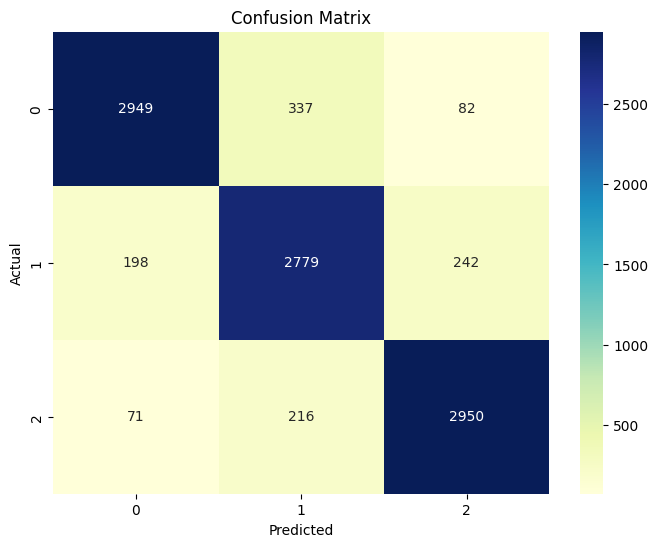

In [59]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score
import seaborn as sns


# Accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print("Test Accuracy : {:.2f}%".format(test_accuracy * 100))

# F1 Score
f1 = f1_score(test_labels, test_preds, average='weighted')
print("F1 Score : {:.2f}%".format(f1 * 100))

# Recall
recall = recall_score(test_labels, test_preds, average='weighted')
print("Recall Score : {:.2f}%".format(recall * 100))

# classification_report
class_report = classification_report(test_labels, test_preds)
print("Classification Report:")
print(class_report)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()